In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-pj_4srj2
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-pj_4srj2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-35zsnxki/pydoe_ba600d25b54d4ebcb1e6f4dadc0bc887
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-35zsnxki/pydoe_ba600d25b54d4ebcb1e6f4dadc0bc887
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 316 kB 8.9 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=2f04a9268ff7792f04cff0cb88650bdbee05d427a774f43be8021b8f3b58266c
  Stored in directory: /tmp/pip-ephem-wheel-cache-p

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F12
from bayes_optim.search_space import RealSpace

In [3]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f12'
f = F12

samples = space.sample(50000)

In [4]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [5]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [6]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [8]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'cma_es_regret', 'min_dist_to_opt': 'dopt_cma'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_init_regret', 'min_dist_to_opt': 'dopt_init'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'uniform_regret', 'min_dist_to_opt': 'dopt_uni'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_regret', 'min_dist_to_opt': 'dopt_lhs'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'halton_regret', 'min_dist_to_opt': 'dopt_hal'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'sobol_regret', 'min_dist_to_opt': 'dopt_sob'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,7931.797929,0,1.007349,254.464389,1.783049,232279.387235,1.738064,84.596237,1.468334,58534.371890,1.673038,1668.853686,1.384955,4.193472e+09,7.360260e+07
1,888.472181,1,1.684260,448.294770,2.765552,40006.366296,2.404064,2230.669884,0.929992,1133.412513,2.458174,3070.170670,3.157927,5.931386e+10,6.063611e+09
2,84.181734,2,1.260922,216.617280,3.651258,70897.125412,2.827859,132113.772990,3.957699,38639.061936,3.106208,80047.271964,0.838488,1.685210e+11,5.406498e+09
3,3.051259,3,3.091063,723761.000305,1.860907,21584.524160,0.847234,9307.488625,2.259305,569.838772,4.022065,1521.362389,0.652716,1.024261e+11,3.545597e+09
4,2198.842823,4,1.619556,653.594849,0.644345,269.886182,1.133699,105.370176,1.801873,3804.543857,2.323823,1276.585396,1.700742,5.599518e+07,9.055668e+06


# CMA-ES vs first individual (generated by LHS)

In [9]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES improved lhs DoE on 24, (48.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
1,1,888.472181,3070.170670,1.684260,3.157927
2,2,84.181734,80047.271964,1.260922,0.838488
3,3,3.051259,1521.362389,3.091063,0.652716
5,5,1616.578948,323909.030910,0.252741,2.132352
6,6,1028.769456,49844.708275,2.738096,2.073946
13,13,8290.276623,16376.526507,1.608625,1.152030
17,17,32.155585,6335.431142,1.448999,1.368290
19,19,55.583681,43413.897418,1.315915,2.377389
21,21,92.490050,2221.519081,1.566991,0.921846
22,22,207.353817,51036.382566,1.987373,1.874347


In [10]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES worstened lhs DoE on 26, (52.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
0,0,7931.797929,1668.853686,1.007349,1.384955
4,4,2198.842823,1276.585396,1.619556,1.700742
7,7,3111.589288,182.933108,1.595399,1.876180
8,8,965.689909,176.659791,1.847300,1.484704
9,9,245.253138,87.528454,1.875809,0.741622
10,10,2064.526015,29.284710,0.540303,1.363613
11,11,150460.150446,34812.382332,3.390448,0.776705
12,12,1221.969445,122.367482,2.588539,2.137452
14,14,550.309160,195.106312,2.436983,3.354289
15,15,4906.454457,19.591288,2.454008,3.279494


# CMA-ES generated vs Uniform

In [11]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret', 'dopt_cma', 'dopt_uni']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 24, (48.0%) function instances


,f_s,cma_es_regret,uniform_regret,dopt_cma,dopt_uni
2,2,84.181734,216.617280,1.260922,3.651258
3,3,3.051259,723761.000305,3.091063,1.860907
5,5,1616.578948,1731.877363,0.252741,0.252463
6,6,1028.769456,54288.215803,2.738096,0.578206
9,9,245.253138,918.384788,1.875809,2.678317
10,10,2064.526015,4209.118926,0.540303,1.923860
14,14,550.309160,9480.907956,2.436983,5.213890
16,16,182.152901,1043.255041,1.946150,2.130527
18,18,4824.485804,7088.556736,2.984605,3.271894
19,19,55.583681,3178.182795,1.315915,1.783142


# CMA-ES vs LHS

In [12]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret', 'dopt_cma', 'dopt_lhs']]

DoE generated by CMA-ES is better than lhs sampled DoE on 28 (56.0%) function instances


,f_s,cma_es_regret,lhs_regret,dopt_cma,dopt_lhs
0,0,7931.797929,232279.387235,1.007349,1.738064
1,1,888.472181,40006.366296,1.684260,2.404064
2,2,84.181734,70897.125412,1.260922,2.827859
3,3,3.051259,21584.524160,3.091063,0.847234
5,5,1616.578948,192675.044137,0.252741,1.516913
6,6,1028.769456,8654.507956,2.738096,1.253677
8,8,965.689909,2910.237017,1.847300,1.051816
9,9,245.253138,1482.453082,1.875809,2.192754
12,12,1221.969445,1919.053412,2.588539,1.774725
14,14,550.309160,4705.625654,2.436983,1.067890


# CMA-ES vs Sobol

In [13]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret', 'dopt_cma', 'dopt_sob']]

DoE generated by CMA-ES is better than sobol generated DoE on 29 (58.0%) function instances


,f_s,cma_es_regret,sobol_regret,dopt_cma,dopt_sob
1,1,888.472181,2230.669884,1.684260,0.929992
2,2,84.181734,132113.772990,1.260922,3.957699
3,3,3.051259,9307.488625,3.091063,2.259305
5,5,1616.578948,9549.294594,0.252741,0.951469
6,6,1028.769456,119622.038447,2.738096,1.873190
8,8,965.689909,21258.304864,1.847300,1.223875
10,10,2064.526015,2470.388194,0.540303,1.937599
13,13,8290.276623,14617.942600,1.608625,2.495886
14,14,550.309160,3555.052797,2.436983,3.488826
16,16,182.152901,996.916387,1.946150,3.368924


# CMA-ES vs Halton

In [14]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret', 'dopt_cma', 'dopt_hal']]

DoE generated by CMA-ES is better than halton generated DoE on 25 (50.0%) function instances


,f_s,cma_es_regret,halton_regret,dopt_cma,dopt_hal
0,0,7931.797929,58534.371890,1.007349,1.673038
1,1,888.472181,1133.412513,1.684260,2.458174
2,2,84.181734,38639.061936,1.260922,3.106208
3,3,3.051259,569.838772,3.091063,4.022065
4,4,2198.842823,3804.543857,1.619556,2.323823
8,8,965.689909,2445.030659,1.847300,2.723101
10,10,2064.526015,14684.993366,0.540303,2.364917
14,14,550.309160,14941.192548,2.436983,3.071802
17,17,32.155585,76.409507,1.448999,1.306324
18,18,4824.485804,8214.973733,2.984605,1.387057


In [15]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 10 (20.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
2,84.181734,2,1.260922,216.617280,3.651258,70897.125412,2.827859,132113.772990,3.957699,38639.061936,3.106208,80047.271964,0.838488,1.685210e+11,5.406498e+09
3,3.051259,3,3.091063,723761.000305,1.860907,21584.524160,0.847234,9307.488625,2.259305,569.838772,4.022065,1521.362389,0.652716,1.024261e+11,3.545597e+09
14,550.309160,14,2.436983,9480.907956,5.213890,4705.625654,1.067890,3555.052797,3.488826,14941.192548,3.071802,195.106312,3.354289,4.522264e+10,3.797421e+09
18,4824.485804,18,2.984605,7088.556736,3.271894,32794.645144,1.705361,121639.385928,1.398422,8214.973733,1.387057,1762.070622,2.905282,2.673192e+11,8.098328e+09
19,55.583681,19,1.315915,3178.182795,1.783142,91.004268,0.468641,131.705803,1.779954,11034.575008,1.050088,43413.897418,2.377389,1.488849e+09,3.845860e+07
21,92.490050,21,1.566991,1924.228955,3.519293,5701.437003,1.376074,1415.909801,2.089041,368.169071,2.881158,2221.519081,0.921846,7.317303e+07,1.982727e+07
24,1846.994684,24,2.492768,42923.518649,1.088008,10173.818185,3.162924,71117.972161,1.097486,9279.385090,2.023401,43687.033184,1.320061,2.837963e+10,6.104929e+08
28,334.716313,28,1.697043,20179.322794,1.913315,24023.935718,2.380764,97608.321057,1.699189,57135.022727,1.071232,35804.658746,1.511602,1.304562e+11,3.124443e+09
30,34.041542,30,2.653364,1374.048891,0.588811,684.556271,1.761817,5372.965579,1.792402,3296.692048,0.962073,272.460999,0.180698,4.294669e+08,3.703259e+07
34,425.511293,34,3.084210,14148.810354,0.805315,13535.657187,3.720046,2732.598067,1.651321,20378.893229,0.949533,22890.813067,0.749634,3.520764e+08,2.054423e+07


In [16]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniformly sampled DoE is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniformly sampled DoE is the best on 13 (26.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
1,888.472181,1,1.684260,448.294770,2.765552,40006.366296,2.404064,2230.669884,0.929992,1133.412513,2.458174,3070.170670,3.157927,5.931386e+10,6.063611e+09
7,3111.589288,7,1.595399,91.535708,1.273094,238.598216,1.629055,944.635886,1.091216,210.997632,1.226643,182.933108,1.876180,3.330585e+08,2.257634e+07
8,965.689909,8,1.847300,611.900511,4.119584,2910.237017,1.051816,21258.304864,1.223875,2445.030659,2.723101,176.659791,1.484704,8.950553e+08,2.086302e+07
12,1221.969445,12,2.588539,496.686694,1.582166,1919.053412,1.774725,872.481164,1.789219,718.863844,2.436255,122.367482,2.137452,6.553935e+07,1.609033e+07
17,32.155585,17,1.448999,0.240699,2.894016,546.330954,0.884702,3197.845877,0.986721,76.409507,1.306324,6335.431142,1.368290,6.058201e+07,1.629968e+07
25,79.391133,25,3.108612,2.844914,0.551134,59.669392,2.618453,3417.392066,2.570019,1260.487337,1.518993,62.578278,0.879046,5.002172e+07,8.639728e+06
27,21545.346262,27,2.818741,107.932595,1.231071,4633.344019,1.403091,525.916640,1.033367,5008.201370,1.081493,24072.852621,0.907776,6.285136e+08,4.217261e+07
35,14645.370278,35,2.293753,187.856362,1.280985,55461.998195,2.592514,1142.769700,0.575235,1034.102706,1.050879,790.525080,1.701430,1.566941e+09,4.266170e+07
37,31.860181,37,3.172037,14.751004,1.541929,1351.263039,1.968419,1198.081600,0.660083,113.091280,3.144811,188.338577,1.251113,2.514869e+09,1.688820e+08
38,2810.090128,38,2.092624,93.098723,0.144926,27005.126271,0.970365,12229.153436,2.682238,12555.926448,2.465887,49667.697471,0.428491,1.524809e+10,4.703549e+08


In [17]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton sequence is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton sequence is the best on 13 (26.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
5,1616.578948,5,0.252741,1731.877363,0.252463,192675.044137,1.516913,9549.294594,0.951469,483.268226,1.639487,323909.030910,2.132352,1.877127e+09,3.482528e+07
6,1028.769456,6,2.738096,54288.215803,0.578206,8654.507956,1.253677,119622.038447,1.873190,87.386737,1.094649,49844.708275,2.073946,6.606059e+09,2.773503e+08
9,245.253138,9,1.875809,918.384788,2.678317,1482.453082,2.192754,221.027010,0.594322,29.947892,1.259310,87.528454,0.741622,5.786190e+08,1.714582e+07
16,182.152901,16,1.946150,1043.255041,2.130527,882.214462,1.755389,996.916387,3.368924,42.709990,1.573175,29.181807,0.600640,7.533784e+07,1.511572e+07
29,19385.534307,29,2.134791,907.049743,0.598818,2402.539945,2.037002,11251.697749,1.611805,289.956409,1.885558,1609.876368,1.463649,1.247926e+08,1.453718e+07
31,2494.818270,31,2.163877,12817.447285,2.518690,23485.906032,1.506391,69199.702109,1.284769,142.044203,1.396242,9528.122642,1.968460,2.719507e+10,7.205754e+08
33,648.511060,33,1.053975,2829.776578,4.860159,3069.593724,2.112136,1027.715472,0.928558,240.468701,1.470236,12035.701605,2.993993,6.787086e+07,1.923931e+07
36,3661.400742,36,2.645806,17698.197594,2.266508,135.853098,0.571571,278.942142,1.316424,22.986269,2.794134,24.248109,0.652379,1.909902e+08,1.309665e+07
39,284052.966992,39,1.331363,45441.121985,1.611359,7815.965304,2.573160,12981.992117,2.448908,6236.148732,1.204519,514.367663,1.850095,6.086870e+10,2.383732e+09
42,26327.589580,42,1.859038,69904.185057,4.139055,972.662842,0.997254,27332.546220,1.680466,6.147182,2.099830,28232.343029,2.439863,6.753895e+10,5.514441e+09


In [18]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 6 (12.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
10,2064.526015,10,0.540303,4209.118926,1.923860,1815.326544,1.571984,2470.388194,1.937599,14684.993366,2.364917,29.284710,1.363613,3.514768e+08,2.101168e+07
13,8290.276623,13,1.608625,248.865789,1.820731,49.545035,1.214508,14617.942600,2.495886,4645.792949,1.268002,16376.526507,1.152030,7.404078e+07,2.140464e+07
20,15927.832143,20,1.627863,2464.889943,0.570832,639.574621,1.261215,717.781815,2.489243,861.362252,0.975618,48.105057,1.705648,8.028143e+08,2.977815e+07
26,408.279085,26,2.097910,2453.715338,1.499807,292.084459,1.175424,22295.867437,0.306022,4883.311744,1.215753,69.844634,1.145503,9.888804e+07,2.420985e+07
43,318.477120,43,1.849051,4036.112142,3.473430,123.981532,2.112074,3009.894261,0.942394,1881.110986,1.450223,354.202440,1.601392,8.321919e+07,2.426865e+07
47,62176.253383,47,2.711474,13887.729669,3.357988,4897.018713,1.921454,4980.346446,0.594246,22052.815457,1.034905,17654.928570,2.760673,1.874242e+10,1.788522e+09


In [19]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 11 (22.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
8,965.689909,8,1.847300,611.900511,4.119584,2910.237017,1.051816,21258.304864,1.223875,2445.030659,2.723101,176.659791,1.484704,8.950553e+08,2.086302e+07
10,2064.526015,10,0.540303,4209.118926,1.923860,1815.326544,1.571984,2470.388194,1.937599,14684.993366,2.364917,29.284710,1.363613,3.514768e+08,2.101168e+07
12,1221.969445,12,2.588539,496.686694,1.582166,1919.053412,1.774725,872.481164,1.789219,718.863844,2.436255,122.367482,2.137452,6.553935e+07,1.609033e+07
14,550.309160,14,2.436983,9480.907956,5.213890,4705.625654,1.067890,3555.052797,3.488826,14941.192548,3.071802,195.106312,3.354289,4.522264e+10,3.797421e+09
15,4906.454457,15,2.454008,171.878461,4.528454,391.517444,1.653998,168.855321,2.260120,213.292370,1.779746,19.591288,3.279494,7.337440e+07,2.115927e+07
16,182.152901,16,1.946150,1043.255041,2.130527,882.214462,1.755389,996.916387,3.368924,42.709990,1.573175,29.181807,0.600640,7.533784e+07,1.511572e+07
18,4824.485804,18,2.984605,7088.556736,3.271894,32794.645144,1.705361,121639.385928,1.398422,8214.973733,1.387057,1762.070622,2.905282,2.673192e+11,8.098328e+09
20,15927.832143,20,1.627863,2464.889943,0.570832,639.574621,1.261215,717.781815,2.489243,861.362252,0.975618,48.105057,1.705648,8.028143e+08,2.977815e+07
26,408.279085,26,2.097910,2453.715338,1.499807,292.084459,1.175424,22295.867437,0.306022,4883.311744,1.215753,69.844634,1.145503,9.888804e+07,2.420985e+07
39,284052.966992,39,1.331363,45441.121985,1.611359,7815.965304,2.573160,12981.992117,2.448908,6236.148732,1.204519,514.367663,1.850095,6.086870e+10,2.383732e+09


In [20]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol sequence is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol sequence is the best on 8 (16.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,7931.797929,0,1.007349,254.464389,1.783049,232279.387235,1.738064,84.596237,1.468334,58534.371890,1.673038,1668.853686,1.384955,4.193472e+09,7.360260e+07
4,2198.842823,4,1.619556,653.594849,0.644345,269.886182,1.133699,105.370176,1.801873,3804.543857,2.323823,1276.585396,1.700742,5.599518e+07,9.055668e+06
11,150460.150446,11,3.390448,36302.567934,3.078625,58841.114036,0.816873,5935.069212,1.327453,36689.833272,1.613451,34812.382332,0.776705,2.806217e+10,8.478871e+08
15,4906.454457,15,2.454008,171.878461,4.528454,391.517444,1.653998,168.855321,2.260120,213.292370,1.779746,19.591288,3.279494,7.337440e+07,2.115927e+07
22,207.353817,22,1.987373,154.648177,1.814291,137.464041,1.954156,13.434837,1.171977,178.494784,1.898270,51036.382566,1.874347,7.953084e+07,2.165924e+07
23,26161.713221,23,2.246165,8788.335245,2.546184,1327.489071,1.672673,86.793395,3.180658,31977.575456,1.095488,6102.359444,2.302931,2.860173e+09,5.290626e+07
32,3570.421820,32,2.588337,41589.008936,2.977154,663.169266,1.358129,55.069964,1.265696,151.868181,0.761861,1145.157032,1.228766,2.109912e+09,6.119499e+07
46,3915.414206,46,1.728993,41435.271852,1.751291,577.527207,1.500500,312.664583,1.576969,406.254312,1.849078,2841.494219,2.459500,9.460868e+08,2.122793e+07


([<matplotlib.axis.XTick at 0x7fd8750e6790>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

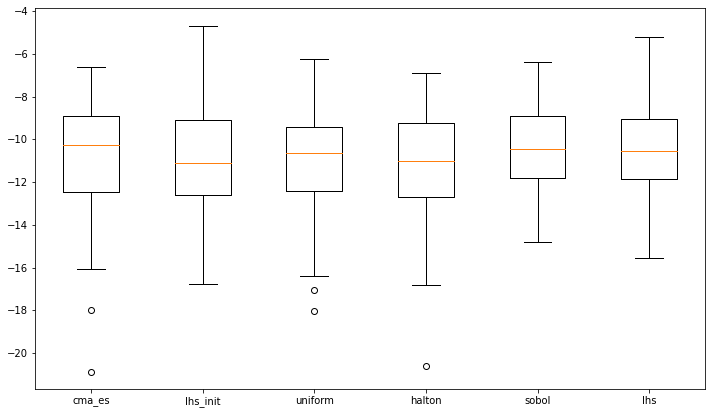

In [21]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7fd874f8b290>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

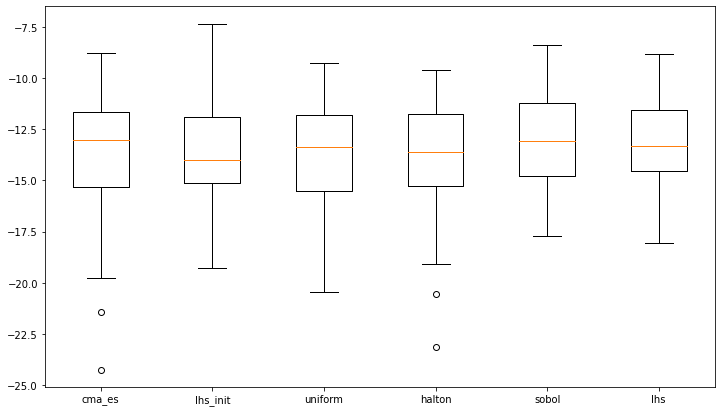

In [22]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)